In [4]:
# !kaggle competitions download -c ieee-fraud-detection

In [5]:
# import zipfile
# with zipfile.ZipFile('ieee-fraud-detection.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

In [6]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, average_precision_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## What we know about the data from discussion in Kaggle?


    TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
    TransactionAMT: transaction payment amount in USD
    ProductCD: product code, the product for each transaction
    card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
    addr: address
    dist: distance
    P_ and (R__) emaildomain: purchaser and recipient email domain
    C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
    D1-D15: timedelta, such as days between previous transaction, etc.
    M1-M9: match, such as names on card and address, etc.
    Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.


In [7]:
train_iden_df = pd.read_csv("data/train_identity.csv")
train_trans_df = pd.read_csv("data/train_transaction.csv")

In [8]:
print('Dimensions of the Train Identity set:',train_iden_df.shape)
print('Dimensions of the Train Transaction set:',train_trans_df.shape)

Dimensions of the Train Identity set: (144233, 41)
Dimensions of the Train Transaction set: (590540, 394)


In [9]:
print('All Transactions IDs from transaction dataset are in identity dataset: ', end= '')
if (np.sum(train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique())) - train_iden_df.shape[0]) == 0:
    print('True')
else:
    print('False')

All Transactions IDs from transaction dataset are in identity dataset: True


In [10]:
train_df=pd.merge(train_trans_df,train_iden_df,how="left",on="TransactionID") # merge df by left
print("Train Dataset shape: ", train_df.shape)

Train Dataset shape:  (590540, 434)


In [11]:
columns_to_print = ['card1','card2','card3','card4','card5','card6']
values = train_df[columns_to_print]
print(values)

        card1  card2  card3       card4  card5   card6
0       13926    NaN  150.0    discover  142.0  credit
1        2755  404.0  150.0  mastercard  102.0  credit
2        4663  490.0  150.0        visa  166.0   debit
3       18132  567.0  150.0  mastercard  117.0   debit
4        4497  514.0  150.0  mastercard  102.0  credit
...       ...    ...    ...         ...    ...     ...
590535   6550    NaN  150.0        visa  226.0   debit
590536  10444  225.0  150.0  mastercard  224.0   debit
590537  12037  595.0  150.0  mastercard  224.0   debit
590538   7826  481.0  150.0  mastercard  224.0   debit
590539  15066  170.0  150.0  mastercard  102.0  credit

[590540 rows x 6 columns]


In [12]:
columns_address = ['C1', 'C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']
found_address = train_df[columns_address]
print(found_address)

         C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3       2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4       1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...
590535  2.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  2.0  0.0  1.0  0.0   3.0  2.0
590536  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
590537  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
590538  1.0  1.0  0.0  0.0  0.0  3.0  0.0  0.0  2.0  0.0  1.0  1.0   5.0  1.0
590539  2.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  1.0  0.0   1.0  1.0

[590540 rows x 14 columns]


In [13]:
columns_transaction_day = ['D1', 'D2','D3','D5','D15']
values_day = train_df[columns_transaction_day]
values_day

,D1,D2,D3,D5,D15
0,14.0,NaN,13.0,NaN,0.0
1,0.0,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,0.0,111.0
4,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,56.0
590536,0.0,NaN,NaN,NaN,0.0
590537,0.0,NaN,NaN,NaN,0.0
590538,22.0,22.0,0.0,0.0,22.0


In [14]:
columns_matchs = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
values_matchs = train_df[columns_matchs]
values_matchs

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,T,T,T,M0,F,T,NaN,NaN,NaN


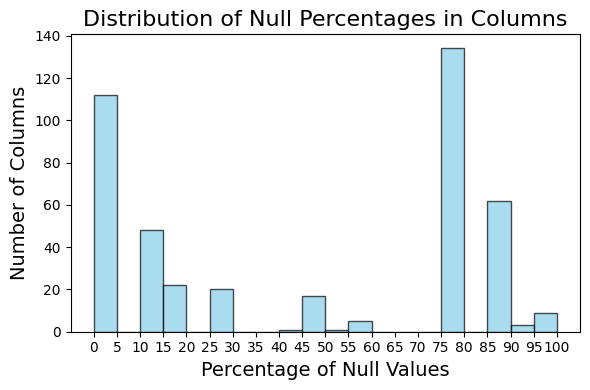

In [15]:
null_percentages = train_df.isnull().mean() * 100

# Create bins for null percentages (e.g., 0-5%, 6-10%, etc.)
bins = range(0, 101, 5)

plt.figure(figsize=(6, 4))
plt.hist(null_percentages, bins=bins, edgecolor='black', alpha=0.7, color='skyblue')

plt.title('Distribution of Null Percentages in Columns', fontsize=16)
plt.xlabel('Percentage of Null Values', fontsize=14)
plt.ylabel('Number of Columns', fontsize=14)
plt.xticks(bins) 

plt.tight_layout()
plt.show()

Are null values valuable for prediction or no? Show null values by class

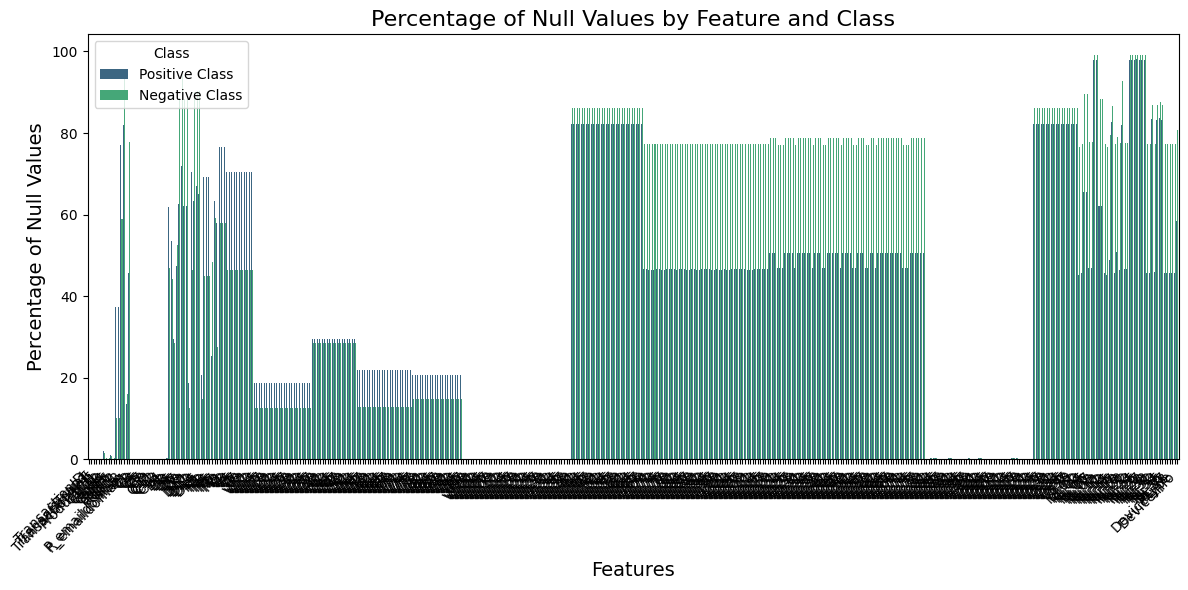

In [16]:
positive_df = train_df[train_df['isFraud'] == 1]
negative_df = train_df[train_df['isFraud'] == 0]

null_percent_positive = positive_df.isnull().mean() * 100
null_percent_negative = negative_df.isnull().mean() * 100

# Create a DataFrame for plotting
null_percent_df = pd.DataFrame({
    'Feature': null_percent_positive.index,
    'Positive Class': null_percent_positive.values,
    'Negative Class': null_percent_negative.values
})

# Melt the DataFrame for seaborn
null_percent_df_melted = null_percent_df.melt(id_vars='Feature', var_name='Class', value_name='Null Percentage')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Null Percentage', hue='Class', data=null_percent_df_melted, palette='viridis')

# Add labels and title
plt.title('Percentage of Null Values by Feature and Class', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Percentage of Null Values', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Class')
plt.tight_layout()
plt.show()

If in a category there are a lot of null values and the percentage of null values is similar across both classes, then drop.

In [17]:
high_null_threshold = 25  # Drop columns with >25% null values
similarity_threshold = 5  # Null percentages by class differ by <= 5%

# Identify columns to drop
columns_to_drop = []
for col in train_df.columns:
    if col == 'isFraud':  # Skip the target column
        continue
    if (null_percent_positive[col] > high_null_threshold and
        null_percent_negative[col] > high_null_threshold and
        abs(null_percent_positive[col] - null_percent_negative[col]) <= similarity_threshold):
        columns_to_drop.append(col)

# Drop the identified columns
train_df_cleaned = train_df.drop(columns=columns_to_drop)

# Print the results
print("Columns dropped:", columns_to_drop)
print("Cleaned DataFrame Shape:", train_df_cleaned.shape)

Columns dropped: ['D4', 'M5', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_07', 'id_08', 'id_14', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']
Cleaned DataFrame Shape: (590540, 353)


    For categorical columns: If the difference in null percentages between fraud and non-fraud cases is significant, it creates a new category called "Unknown" for null values.

    For numerical columns:

        If 0 isn't already a value in the column, it replaces nulls with 0.

        If 0 is already present, it replaces nulls with the median value.

        If the difference in null percentages is very large (over 40%), it adds a flag column to mark where the nulls were.

    For all other columns: If the difference in null percentages isn't significant, it fills nulls with the mode for categorical columns or the median for numerical columns.

In [18]:
newclass_percentage = 0.2

positive_class = train_df_cleaned[train_df['isFraud'] == 1]
negative_class = train_df_cleaned[train_df['isFraud'] == 0]

null_percent_positive = positive_class.isnull().mean() * 100
null_percent_negative = negative_class.isnull().mean() * 100

# Iterate through each column
for col in train_df_cleaned.columns:
    if col == 'isFraud': 
        continue

    diff = abs(null_percent_positive[col] - null_percent_negative[col])

    if diff > newclass_percentage * max(null_percent_positive[col], null_percent_negative[col]) and max(null_percent_positive[col], null_percent_negative[col]) > 5:
        if train_df_cleaned[col].dtype == 'object' or train_df_cleaned[col].dtype.name == 'category':
            # Create a new category for null values
            train_df_cleaned[col] = train_df_cleaned[col].fillna("Unknown")
            print(f"Created new category 'Unknown' for null values in '{col}'.")

        # Handle numerical columns
        elif np.issubdtype(train_df_cleaned[col].dtype, np.number):
            if 0 not in train_df_cleaned[col].unique():
                train_df_cleaned[col] = train_df_cleaned[col].fillna(0)
            else:
                # Replace nulls with the median
                median_value = train_df_cleaned[col].median()
                train_df_cleaned[col] = train_df_cleaned[col].fillna(median_value)
                if diff > 0.4 * max(null_percent_positive[col], null_percent_negative[col]):
                    # Create a new flag column for null values
                    train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
                    print(f"Created new flag column '{col}_isnull' for null values in '{col}'.")
    # Handle all other columns (no significant difference in null percentages)
    else:
        if train_df_cleaned[col].dtype == 'object' or train_df_cleaned[col].dtype.name == 'category':
            mode_value = train_df_cleaned[col].mode()[0]
            train_df_cleaned[col] = train_df_cleaned[col].fillna(mode_value)
        elif np.issubdtype(train_df_cleaned[col].dtype, np.number):
            median_value = train_df_cleaned[col].median()
            train_df_cleaned[col] = train_df_cleaned[col].fillna(median_value)

Created new category 'Unknown' for null values in 'R_emaildomain'.
Created new category 'Unknown' for null values in 'M1'.
Created new category 'Unknown' for null values in 'M2'.
Created new category 'Unknown' for null values in 'M3'.
Created new category 'Unknown' for null values in 'M4'.
Created new category 'Unknown' for null values in 'M6'.
Created new category 'Unknown' for null values in 'M7'.
Created new category 'Unknown' for null values in 'M8'.
Created new category 'Unknown' for null values in 'M9'.
Created new flag column 'V53_isnull' for null values in 'V53'.
Created new flag column 'V54_isnull' for null values in 'V54'.
Created new flag column 'V55_isnull' for null values in 'V55'.
Created new flag column 'V56_isnull' for null values in 'V56'.
Created new flag column 'V57_isnull' for null values in 'V57'.
Created new flag column 'V58_isnull' for null values in 'V58'.
Created new flag column 'V59_isnull' for null values in 'V59'.


C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

Created new flag column 'V60_isnull' for null values in 'V60'.
Created new flag column 'V61_isnull' for null values in 'V61'.
Created new flag column 'V62_isnull' for null values in 'V62'.
Created new flag column 'V63_isnull' for null values in 'V63'.
Created new flag column 'V64_isnull' for null values in 'V64'.
Created new flag column 'V65_isnull' for null values in 'V65'.
Created new flag column 'V66_isnull' for null values in 'V66'.


C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

Created new flag column 'V67_isnull' for null values in 'V67'.
Created new flag column 'V68_isnull' for null values in 'V68'.
Created new flag column 'V69_isnull' for null values in 'V69'.
Created new flag column 'V70_isnull' for null values in 'V70'.
Created new flag column 'V71_isnull' for null values in 'V71'.
Created new flag column 'V72_isnull' for null values in 'V72'.
Created new flag column 'V73_isnull' for null values in 'V73'.
Created new flag column 'V74_isnull' for null values in 'V74'.


C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

Created new flag column 'V169_isnull' for null values in 'V169'.
Created new flag column 'V170_isnull' for null values in 'V170'.
Created new flag column 'V171_isnull' for null values in 'V171'.
Created new flag column 'V174_isnull' for null values in 'V174'.
Created new flag column 'V175_isnull' for null values in 'V175'.


C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

Created new flag column 'V180_isnull' for null values in 'V180'.
Created new flag column 'V184_isnull' for null values in 'V184'.
Created new flag column 'V185_isnull' for null values in 'V185'.
Created new flag column 'V188_isnull' for null values in 'V188'.
Created new flag column 'V189_isnull' for null values in 'V189'.


C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

Created new flag column 'V194_isnull' for null values in 'V194'.
Created new flag column 'V195_isnull' for null values in 'V195'.
Created new flag column 'V197_isnull' for null values in 'V197'.
Created new flag column 'V198_isnull' for null values in 'V198'.
Created new flag column 'V200_isnull' for null values in 'V200'.
Created new flag column 'V201_isnull' for null values in 'V201'.


C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)
C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

Created new flag column 'V208_isnull' for null values in 'V208'.
Created new flag column 'V209_isnull' for null values in 'V209'.
Created new flag column 'V210_isnull' for null values in 'V210'.


C:\Users\Джамиля\AppData\Local\Temp\ipykernel_11704\4261330437.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_cleaned[f'{col}_isnull'] = train_df_cleaned[col].isnull().astype(int)


Created new flag column 'id_01_isnull' for null values in 'id_01'.
Created new category 'Unknown' for null values in 'id_12'.
Created new category 'Unknown' for null values in 'id_15'.
Created new category 'Unknown' for null values in 'id_16'.
Created new category 'Unknown' for null values in 'id_28'.
Created new category 'Unknown' for null values in 'id_29'.
Created new category 'Unknown' for null values in 'id_31'.
Created new category 'Unknown' for null values in 'id_35'.
Created new category 'Unknown' for null values in 'id_36'.
Created new category 'Unknown' for null values in 'id_37'.
Created new category 'Unknown' for null values in 'id_38'.
Created new category 'Unknown' for null values in 'DeviceType'.
Created new category 'Unknown' for null values in 'DeviceInfo'.


Check if succesfully got rid of all null values

In [19]:
# Print columns with null values and their counts
null_counts = train_df_cleaned.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


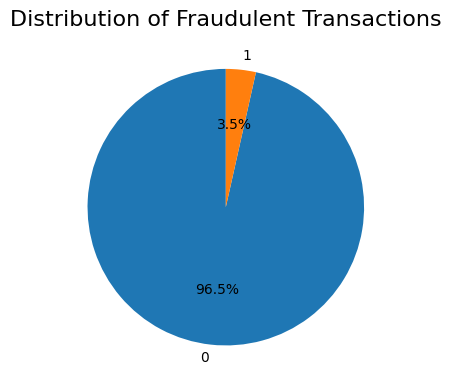

In [20]:
fraud_counts = train_df_cleaned['isFraud'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Fraudulent Transactions', fontsize=16)

plt.tight_layout()
plt.show()

In [21]:
train_df_cleaned.shape

(590540, 395)

## Preprosesing:
From Kaggle Data section we now that:

Categorical Features - Transaction

    ProductCD
    card1 - card6
    addr1, addr2
    P_emaildomain
    R_emaildomain
    M1 - M9

Categorical Features - Identity

    DeviceType
    DeviceInfo
    id_12 - id_38


+ there are flag columns

Encode categorical features and flag columns

In [22]:
# Identify categorical columns
categorical_cols = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'DeviceType', 'DeviceInfo',
    'id_12', 'id_15', 'id_16'
]


numerical_cols = list()
for column in train_df_cleaned:
    if column not in categorical_cols:
        numerical_cols.append(column)

In [23]:
X = train_df_cleaned.drop('isFraud', axis=1)
y = train_df_cleaned['isFraud']

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [24]:
from sklearn.preprocessing import OrdinalEncoder

# Identify which categorical columns actually exist in your data
categorical_cols = [
    'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'P_emaildomain', 'R_emaildomain',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'DeviceType', 'DeviceInfo',
    'id_12', 'id_15', 'id_16'
]

# Filter to only columns that exist
categorical_cols = [col for col in categorical_cols if col in X_train.columns]

# Identify numerical columns (make sure these exist too)
numerical_cols = [col for col in ['TransactionAmt'] if col in X_train.columns]

# Split into high/low cardinality
high_cardinality = []
low_cardinality = []
for col in categorical_cols:
    if X_train[col].nunique() > 10:
        high_cardinality.append(col)
    else:
        low_cardinality.append(col)

In [25]:
X_test

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V194_isnull,V195_isnull,V197_isnull,V198_isnull,V200_isnull,V201_isnull,V208_isnull,V209_isnull,V210_isnull,id_01_isnull
380364,3367364,9508466,59.000,W,17188,321.0,150.0,visa,226.0,debit,...,0,0,0,0,0,0,0,0,0,0
116924,3103924,2261304,61.565,C,16136,204.0,185.0,visa,138.0,debit,...,0,0,0,0,0,0,0,0,0,0
125476,3112476,2487815,34.000,W,12577,268.0,150.0,visa,166.0,debit,...,0,0,0,0,0,0,0,0,0,0
331579,3318579,8154646,49.000,W,13481,445.0,150.0,mastercard,224.0,debit,...,0,0,0,0,0,0,0,0,0,0
154229,3141229,3189143,604.630,W,15066,170.0,150.0,mastercard,102.0,credit,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327207,3314207,8044026,51.500,W,12577,268.0,150.0,visa,166.0,debit,...,0,0,0,0,0,0,0,0,0,0
419423,3406423,10613858,57.950,W,18132,567.0,150.0,mastercard,117.0,debit,...,0,0,0,0,0,0,0,0,0,0
542483,3529483,14316300,107.950,W,4806,490.0,150.0,visa,226.0,debit,...,0,0,0,0,0,0,0,0,0,0
123963,3110963,2432143,411.950,W,6697,111.0,150.0,visa,195.0,debit,...,0,0,0,0,0,0,0,0,0,0


scale and split the data into train and test

In [ ]:
def train_models(X_train, y_train):
    # Class weights for imbalance
    fraud_ratio = y_train.mean()
    class_weight = {0: 1, 1: (1 - fraud_ratio)/fraud_ratio}
    
    # Shared preprocessor
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('low_card', OneHotEncoder(handle_unknown='ignore'), low_cardinality),
        ('high_card', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), high_cardinality)
    ])
    
    models = {
        'RandomForest': Pipeline([
            ('preprocess', preprocessor),
            ('model', RandomForestClassifier(
                class_weight=class_weight,
                n_jobs=-1,
                random_state=42))
        ]),
        'GradientBoosting': Pipeline([
            ('preprocess', preprocessor),
            ('model', GradientBoostingClassifier(random_state=42))
        ]),
        # 'SVM': Pipeline([
        #     ('preprocess', preprocessor),
        #     ('model', SVC(
        #         class_weight=class_weight,
        #         probability=True,
        #         kernel='rbf',  # Better for non-linear problems
        #         C=1.0,         # Regularization parameter
        #         gamma='scale',  # Kernel coefficient
        #         random_state=42))
        # ])
    }
    
    # Train all models
    trained_models = {}
    for name, pipeline in models.items():
        print(f"Training {name}...")
        pipeline.fit(X_train, y_train)
        trained_models[name] = pipeline
    return trained_models

In [27]:
def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Get predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Store metrics
        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_prob),
            'average_precision': average_precision_score(y_test, y_prob)
        }
        
        # Print summary
        print(f"\n{name} Performance:")
        print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
        print(f"Avg Precision: {results[name]['average_precision']:.4f}")
        print("Confusion Matrix:")
        print(results[name]['confusion_matrix'])
    
    return results

In [ ]:
# 3. Train models
print("\nTraining models...")
trained_models = train_models(X_train, y_train)

# 4. Evaluate models
print("\nEvaluating models...")
results = evaluate_models(trained_models, X_test, y_test)


Training models...
Training RandomForest...
Training GradientBoosting...
Training SVM...
